## Solutions

### Exercise 1

Look ahead estimation of a TAR stationary density, where the TAR model
is

$$
X_{t+1} = \theta |X_t| + (1 - \theta^2)^{1/2} \xi_{t+1}
$$

and $ \xi_t \sim N(0,1) $

Try running at `n = 10, 100, 1000, 10000` to get an idea of the speed of convergence

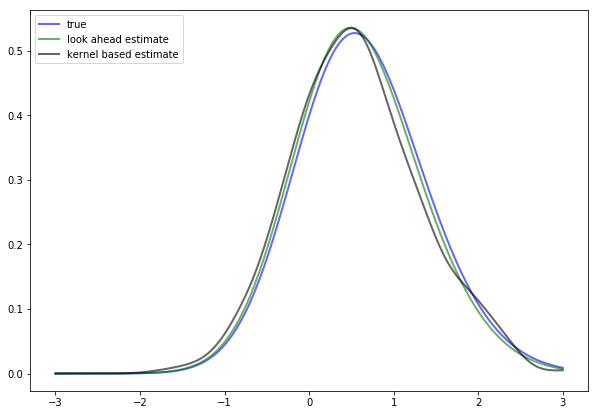

In [4]:
from scipy.stats import norm, gaussian_kde

ϕ = norm()
n = 500
θ = 0.8
# == Frequently used constants == #
d = np.sqrt(1 - θ**2)
δ = θ / d

def ψ_star(y):
    "True stationary density of the TAR Model"
    return 2 * norm.pdf(y) * norm.cdf(δ * y)

def p(x, y):
    "Stochastic kernel for the TAR model."
    return ϕ.pdf((y - θ * np.abs(x)) / d) / d

Z = ϕ.rvs(n)
X = np.empty(n)
for t in range(n-1):
    X[t+1] = θ * np.abs(X[t]) + d * Z[t]
ψ_est = LAE(p, X)
k_est = gaussian_kde(X)

fig, ax = plt.subplots(figsize=(10, 7))
ys = np.linspace(-3, 3, 200)
ax.plot(ys, ψ_star(ys), 'b-', lw=2, alpha=0.6, label='true')
ax.plot(ys, ψ_est(ys), 'g-', lw=2, alpha=0.6, label='look ahead estimate')
ax.plot(ys, k_est(ys), 'k-', lw=2, alpha=0.6, label='kernel based estimate')
ax.legend(loc='upper left')
plt.show()

### Exercise 2

Here’s one program that does the job

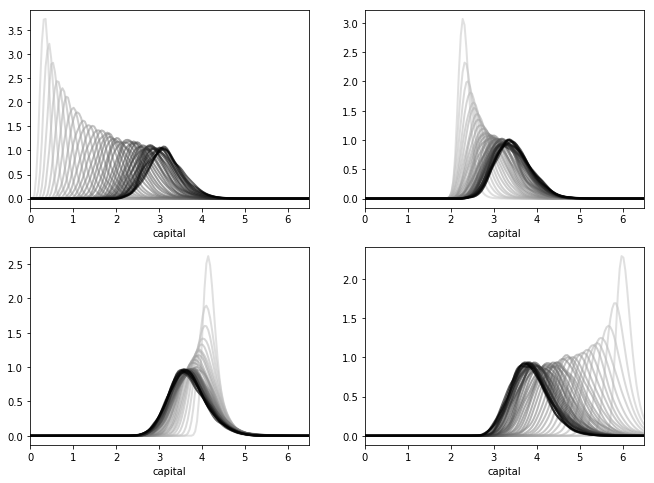

In [5]:
# == Define parameters == #
s = 0.2
δ = 0.1
a_σ = 0.4                                # A = exp(B) where B ~ N(0, a_σ)
α = 0.4                                  # f(k) = k**α

ϕ = lognorm(a_σ)

def p(x, y):
    "Stochastic kernel, vectorized in x.  Both x and y must be positive."
    d = s * x**α
    return ϕ.pdf((y - (1 - δ) * x) / d) / d

n = 1000                                 # Number of observations at each date t
T = 40                                   # Compute density of k_t at 1,...,T

fig, axes = plt.subplots(2, 2, figsize=(11, 8))
axes = axes.flatten()
xmax = 6.5

for i in range(4):
    ax = axes[i]
    ax.set_xlim(0, xmax)
    ψ_0 = beta(5, 5, scale=0.5, loc=i*2)  # Initial distribution

    # == Generate matrix s.t. t-th column is n observations of k_t == #
    k = np.empty((n, T))
    A = ϕ.rvs((n, T))
    k[:, 0] = ψ_0.rvs(n)
    for t in range(T-1):
        k[:, t+1] = s * A[:,t] * k[:, t]**α + (1 - δ) * k[:, t]

    # == Generate T instances of lae using this data, one for each t == #
    laes = [LAE(p, k[:, t]) for t in range(T)]

    ygrid = np.linspace(0.01, xmax, 150)
    greys = [str(g) for g in np.linspace(0.0, 0.8, T)]
    greys.reverse()
    for ψ, g in zip(laes, greys):
        ax.plot(ygrid, ψ(ygrid), color=g, lw=2, alpha=0.6)
    ax.set_xlabel('capital')
plt.show()

### Exercise 3

Here’s a possible solution

Note the way we use vectorized code to simulate the $ k $ time
series for one boxplot all at once

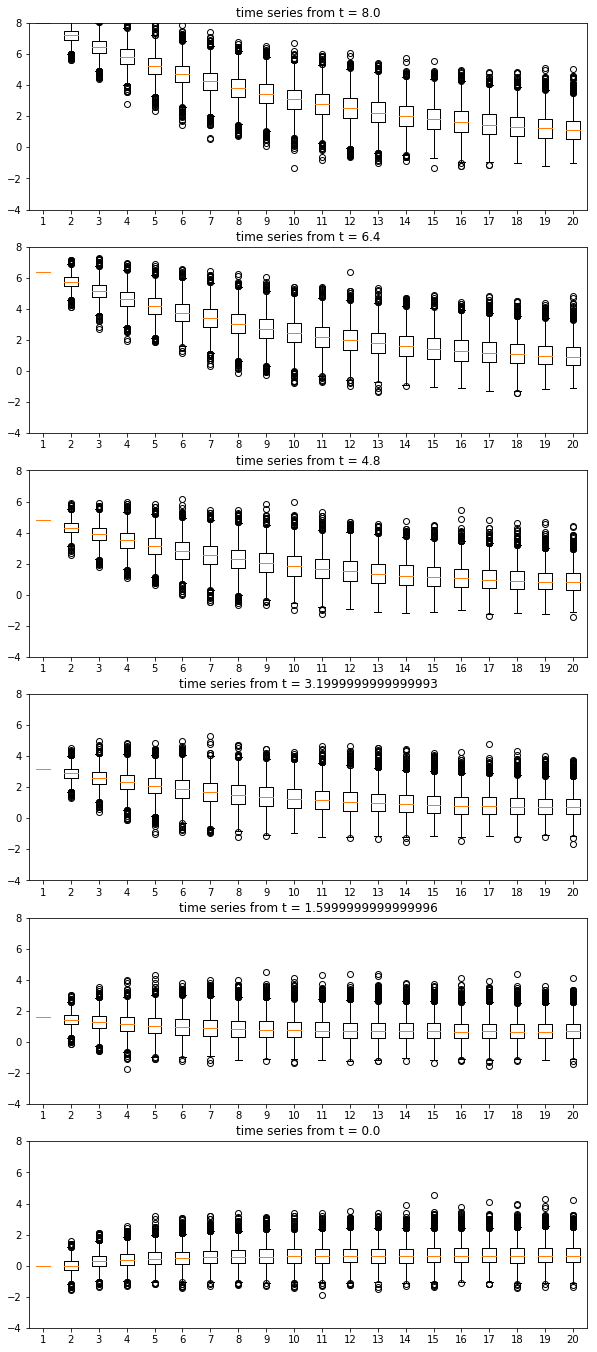

In [6]:
n = 20
k = 5000
J = 6

θ = 0.9
d = np.sqrt(1 - θ**2)
δ = θ / d

fig, axes = plt.subplots(J, 1, figsize=(10, 4*J))
initial_conditions = np.linspace(8, 0, J)
X = np.empty((k, n))

for j in range(J):

    axes[j].set_ylim(-4, 8)
    axes[j].set_title(f'time series from t = {initial_conditions[j]}')

    Z = np.random.randn(k, n)
    X[:, 0] = initial_conditions[j]
    for t in range(1, n):
        X[:, t] = θ * np.abs(X[:, t-1]) + d * Z[:, t]
    axes[j].boxplot(X)

plt.show()